In the previous sections, I have performed both Feature Engineering and Feature Selection. In this Notebook, I will perform both hyperparameter tuning and model validation. <br>
<br>
I will once again check the scores of all classification models baed on the selected features and then choose those models for hyperparameter tuning and subsequent model validation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

#Importing Classification algorithms

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    SGDClassifier,
    Perceptron,
    PassiveAggressiveClassifier,
    RidgeClassifier, 
    RidgeClassifierCV
)

from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import  GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from rgf.sklearn import RGFClassifier, FastRGFClassifier
from gpboost import GPBoostClassifier
from ngboost import NGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    ExtraTreesClassifier, 
    IsolationForest, 
    BaggingClassifier, 
    HistGradientBoostingClassifier
)

from imblearn.ensemble import (
    EasyEnsembleClassifier, 
    RUSBoostClassifier, 
    BalancedBaggingClassifier, 
    BalancedRandomForestClassifier 
)

from numpy import interp

#Class for creating progressbar
class Progress:
    def __init__(self, value, end, title='Progress',buffer=100):
        self.title = title
        #when calling in a for loop it doesn't include the last number
        self.end = end 
        self.buffer = buffer
        self.value = value + 1
        self.progress()

    def progress(self):
        maped = int(interp(self.value, [0, self.end], [0, self.buffer]))
        print(f'{self.title}: [{"#"*maped}{"-"*(self.buffer - maped)}]{self.value}/{self.end} {((self.value/self.end)*100):.2f}%', end='\r')

from sklearn import set_config
set_config(display='diagram')        

seed = 42

In [2]:
X_train_pars = pd.read_csv('X_train_pars.csv') #Training set
X_test_pars = pd.read_csv('X_test_pars.csv') # validation set
TEST_DF_pars = pd.read_csv('TEST_DF_pars.csv') #Test set

y_train = pd.read_csv('y_train.csv') #target train
y_test = pd.read_csv('y_test.csv') #target validation

In [3]:
#For final submission, combining the train and validation set for final model traning.

train = X_train_pars.append(X_test_pars, ignore_index = True)
target = y_train.append(y_test, ignore_index = True)

sub = pd.read_csv('gender_submission.csv')

In [49]:
#Function for selecting the right model

class classif_models:
    
    """
    A Class to cross-validate and evaluate the performance of majority of classification models using 
    various classification metrics.
    """
    
    def __init__(self, Xtrain, ytrain, preprocessor, cv):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.preprocessor = preprocessor 
        self.cv = cv
        
    def check_clf_models(self):
        
        #Models that require scaling
        models = [
            LogisticRegression(random_state = seed),
            LogisticRegressionCV(cv=10, random_state = seed),
            SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2, 
                          random_state = seed),
            Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2, 
                       random_state = seed),
            PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2, 
                                        random_state = seed),
            RidgeClassifier(random_state = seed),
            RidgeClassifierCV(cv=10),
            LinearSVC(loss = 'hinge', random_state = seed),
            SVC(kernel = 'rbf', random_state = seed),
            NuSVC(random_state = seed),
            KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
            GaussianNB(), 
            BernoulliNB(),
            MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            GaussianProcessClassifier(random_state = seed)
        ]
        
        acc = []
        acc_std = []
        f1 = []
        roc_auc = []
        prec = []
        recall = []
        bal_acc = []
        model_names = []
        
        print('Training using Non-Tree based models...')
        for model, i in zip(models, range(len(models))):
            pipe = Pipeline(steps = [('preprocessor', preprocessor), (type(model).__name__, model)])
            
            scores = cross_validate(pipe, 
                                    self.Xtrain, 
                                    self.ytrain,
                                    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall', 
                                               'balanced_accuracy'],
                                    cv = self.cv, 
                                    n_jobs = -1)
            
            acc.append(list(scores.values())[2].mean()*100)
            acc_std.append(list(scores.values())[2].std()*100)
            f1.append(list(scores.values())[3].mean()*100)
            roc_auc.append(list(scores.values())[4].mean()*100)
            prec.append(list(scores.values())[5].mean()*100)
            recall.append(list(scores.values())[6].mean()*100)
            bal_acc.append(list(scores.values())[7].mean()*100)
            
            model_names.append(type(model).__name__)
            Progress(i, len(models))
            
        print()

    #Using Ensemble Models
        #Models that dont require scaling
        tree_models = [
            DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state = seed),
            RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced', 
                                   n_jobs=-1, random_state = seed), 
            XGBClassifier(use_label_encoder=False, eval_metric = 'error', seed = seed), 
            CatBoostClassifier(verbose = False, loss_function='Logloss', eval_metric='TotalF1', 
                               random_seed = seed, auto_class_weights = "Balanced"), 
            LGBMClassifier(random_state = seed), 
            AdaBoostClassifier(random_state = seed), 
            GradientBoostingClassifier(random_state = seed), 
            BaggingClassifier(random_state = seed), 
            ExtraTreesClassifier(criterion='entropy', max_depth=6, class_weight='balanced', n_jobs=-1, 
                                 random_state = seed), 
            HistGradientBoostingClassifier(random_state = seed), 
            EasyEnsembleClassifier(random_state = seed), 
            RUSBoostClassifier(random_state = seed), 
            BalancedBaggingClassifier(random_state = seed), 
            BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6, 
                                           random_state = seed, class_weight = 'balanced'), 
            RGFClassifier(loss = 'Log', algorithm='RGF_Sib'), 
            FastRGFClassifier(loss='LOGISTIC'),
            GPBoostClassifier(random_state = seed)
        ]
        
        print()
        print('Training Using Ensemble models...')
        for model, i in zip(tree_models, range(len(tree_models))):
            
            scores = cross_validate(model, 
                                    self.Xtrain, 
                                    self.ytrain,
                                    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall', 
                                               'balanced_accuracy'],
                                    cv = self.cv, 
                                    n_jobs = -1)
            
            acc.append(list(scores.values())[2].mean()*100)
            acc_std.append(list(scores.values())[2].std()*100)
            f1.append(list(scores.values())[3].mean()*100)
            roc_auc.append(list(scores.values())[4].mean()*100)
            prec.append(list(scores.values())[5].mean()*100)
            recall.append(list(scores.values())[6].mean()*100)
            bal_acc.append(list(scores.values())[7].mean()*100)
            
            model_names.append(type(model).__name__)
            Progress(i, len(tree_models))
        
        #compiling all results to a dataframe
        print()
        self.df = pd.DataFrame({
            'Models': model_names, 
            'Acc %': acc, 
            'Acc STD %': acc_std, 
            'f1 %':f1,
            'ROC_AUC %' :roc_auc, 
            'Precision %': prec,
            'Recall %': recall, 
            'Balanced_Acc %': bal_acc 
        }).sort_values('f1 %', ascending = False, ignore_index = True).style.highlight_max(color = 'green')

        return self.df
    
# classif_models(Xtrain, ytrain, cv)
#.check_clf_models()

In [5]:
X_train_pars

,Pclass,Fare,FamilySize,Title,fare_bin
0,1.140822,90.0000,2.0,1.580189,2.107263
1,0.233532,10.5000,1.0,-1.248735,-0.787846
2,0.233532,13.0000,1.0,-1.248735,0.244044
3,-0.666730,22.0250,3.0,1.580189,-0.052222
4,0.233532,10.5000,1.0,1.580189,-0.787846
...,...,...,...,...,...
663,0.233532,13.8625,1.0,-1.248735,0.011540
664,-0.666730,19.2583,4.0,1.580189,0.011540
665,-0.666730,34.3750,5.0,1.580189,-0.135063
666,1.140822,38.5000,1.0,-1.248735,-0.135063


In [6]:
X_train_pars.columns

Index(['Pclass', 'Fare', 'FamilySize', 'Title', 'fare_bin'], dtype='object')

In [50]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer

preprocessor = StandardScaler()

skf = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True)

all_models = classif_models(X_train_pars, 
                            y_train, 
                            preprocessor = preprocessor,
                            cv = skf)

all_models.check_clf_models()

Training using Non-Tree based models...
Progress: [####################################################################################################]15/15 100.00%

Training Using Ensemble models...
Progress: [####################################################################################################]17/17 100.00%
Wall time: 54 s


,Models,Acc %,Acc STD %,f1 %,ROC_AUC %,Precision %,Recall %,Balanced_Acc %
0,BalancedRandomForestClassifier,84.118046,4.253635,80.536445,88.732958,76.301182,85.553846,84.397132
1,CatBoostClassifier,84.873360,3.777674,80.383899,88.583910,79.857812,81.276923,84.204083
2,RandomForestClassifier,84.120308,4.348962,79.922583,89.178379,77.855032,82.461538,83.826588
3,ExtraTreesClassifier,83.971054,4.440738,79.805646,88.636380,77.341777,82.815385,83.756705
4,BalancedBaggingClassifier,84.276346,2.372187,79.613997,87.614455,78.966688,80.492308,83.573680
5,RGFClassifier,85.332429,4.749329,79.596309,89.034164,84.486797,75.800000,83.532985
6,XGBClassifier,84.579376,2.924961,79.261312,88.251389,81.480612,77.353846,83.218154
7,EasyEnsembleClassifier,82.919493,5.074256,79.021067,87.060431,74.986811,83.953846,83.112231
8,GradientBoostingClassifier,84.427861,4.399961,78.982434,88.868775,81.632459,76.923077,82.999866
9,LGBMClassifier,84.278607,4.029236,78.908315,88.570633,81.005125,77.369231,82.979040


Next, I have created a new class for model validation. The steps involved within the lass are as follows: <br>
<br>
1. 10-fold cross validation of tran set. <br>
2. Summary of results after cross-validation of traning set. <br>
3. Model metrics after predicting on validation set.
4. Threshold Tuning to optimize both f1 and accuracy score.

In [8]:
#for evaluating model

class validate_on_test:
    
    """
    A Class for model validation. This Class also involved optimizing F-score based on beta inorder to
    verify at which threshold max recall or precision can be obtained.
    """
    
    def __init__(self, model, Xtrain, ytrain, Xtest, ytest, cv, beta, optimize):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        self.cv = cv
        self.beta = beta #Beta for F-score
        self.optimize = optimize #Metric to optimize (accuracy or f-score))
        
        self.Xtrain = self.Xtrain.values
        self.ytrain = self.ytrain[self.ytrain.columns[0]].values
        self.Xtest = self.Xtest.values
        self.ytest = self.ytest[self.ytest.columns[0]].values
        
    def evaluate_model(self):
        
        from texttable import Texttable
        t = Texttable()
        
        #To display model name
        if type(self.model).__name__ == 'CalibratedClassifierCV':
            if type(self.model.base_estimator).__name__ == 'Pipeline':
                model_name = 'Cal_' + type(list(self.model.base_estimator.named_steps.items())[1][1]).__name__
            else:
                model_name = 'Cal_' + type(self.model.base_estimator).__name__
        else:
            try: 
                type(list(self.model.named_steps.items())[1][1]).__name__
                
            except AttributeError:
                model_name = type(self.model).__name__
                
            else:
                model_name = type(list(self.model.named_steps.items())[1][1]).__name__
        
        #Table that displays cross-validation results
        print('+' * len(f' {model_name} '))
        print(f' {model_name} ')
        print('+' * len(f' {model_name} '))
        print()

        print('Performing Cross-Validation...')
        print('------------------------------------------')
        t.set_deco(t.VLINES)
        t.add_rows([['CV#', 'Accuracy %', 'f1 Score %', 'ROC-AUC %']], header = False)
        print(t.draw())
        print('------------------------------------------')
        t.reset()
        t.set_deco(t.HLINES)
        
        #An array that holds different thresholds between 0 and 100%.
        thresholds = np.arange(0, 1, 0.001)
        
        # apply threshold to positive probabilities to create labels
        def to_labels(pos_probs, threshold):
            return (pos_probs >= threshold).astype('int64')
        
        #Cross-validation
        accuracy = []
        f1_score = []
        roc_auc_score = []
        fold_no = 1

        for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain):
            X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index]
            y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index]

            classifier = self.model

            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            y_probs = classifier.predict_proba(X_val_kfold)
           
            accuracy.append(np.round(metrics.accuracy_score(y_val_kfold, y_pred)*100,3))
            f1_score.append(np.round(metrics.f1_score(y_val_kfold, y_pred)*100,3))
            roc_auc_score.append(np.round(metrics.roc_auc_score(y_val_kfold, y_probs[:,1])*100,3))
            
            t.set_cols_align(["c", "c", "c", "c"])
            t.add_row([fold_no, accuracy[fold_no-1],  f1_score[fold_no-1],  roc_auc_score[fold_no-1]])
            print(t.draw())
            t.reset()
        
            fold_no += 1
                
        print()
        print(f'*** {model_name} Mean CV Scores ***')
        print('=' * len(f'*** {model_name} Mean CV Scores ***'))
        print(f'ROC AUC   : {np.mean(roc_auc_score):.3f} ± {np.std(roc_auc_score):.1f} %')
        print(f'f1        : {np.mean(f1_score):.3f} ± {np.std(f1_score):.1f} %')
        print(f'Accuracy  : {np.mean(accuracy):.3f} ± {np.std(accuracy):.1f} %')
        print()
        print("---" * 40)
        
        #Predicting on validation set
        y_pred = classifier.predict(self.Xtest)
        y_probs = classifier.predict_proba(self.Xtest)
        
        self.y_probs = y_probs
        
        #Classification report on validation set
        print()
        print('====================================')
        print("Classification report on Test set:")
        print('====================================')
        print()
        print(metrics.classification_report(self.ytest, y_pred))
        print()
        print("---" * 40)
        print()
        
        #results of validation sets
        print(f'*** {model_name} scores on TEST set ***')
        print('=' * len(f'*** {model_name} scores on TEST set ***'))
        print(f'ROC AUC   : {metrics.roc_auc_score(self.ytest, y_probs[:,1])*100:.4f} %')
        print(f'f1        : {metrics.f1_score(self.ytest, y_pred)*100:.4f} %')
        print(f'Accuracy  : {metrics.accuracy_score(self.ytest, y_pred)*100:.4f} %')
        print()
        
        print("---" * 40)
        
        #Beta option. There are 2 ways, either auto or manually inputed beta number.
        
        # If auto, then a beta array containing beta score from 0.5 to 2 is created. Subsequently, 
        #F-score is created for each beta score. The beta and threshold with the highest F-score is 
        #then selected.
        
        #If manual, then the inputed beta score is used to get the best threshold for the highest F-score.
        
        #Also, there are 2 options for optimize: 'fbeta' or 'accuracy'
        #If fbeta, then the index that has the hight f-score is chosen. If accuracy, then the index
        #with highest accuracy is chosen.
        
        if self.beta == 'auto':
            if self.optimize == 'fbeta':
                beta_array = np.arange(0.5,2.05,0.05)

                # evaluate each threshold
                beta_val_array = []
                best_f1 = []
                best_threshold = []
                best_acc = []
                print()
                print('Estimating New Probability Threshold...')

                for b, i in zip(beta_array, range(len(beta_array))):

                    beta_val_array.append(b)

                    fbeta_score = [metrics.fbeta_score(self.ytest, 
                                                       to_labels(self.y_probs[:,1], t), 
                                                       beta = b) for t in thresholds]

                    acc = [metrics.accuracy_score(self.ytest,
                                                  to_labels(self.y_probs[:,1], t)) for t in thresholds]
                    
                    ix = np.argmax(fbeta_score) #Index that has the highest F-score
                        
                    best_f1.append(fbeta_score[ix])
                    best_acc.append(acc[ix])
                    best_threshold.append(thresholds[ix])

                    Progress(i, len(beta_array))
            
                print()
                score_df = pd.DataFrame({
                    'threshold': best_threshold,
                    'Beta' : beta_val_array,
                    'fbeta': best_f1, 
                    'accuracy' : best_acc
                }).sort_values(self.optimize, ascending = False, ignore_index = True)

                self.score_df = score_df
                
                print()
                print('Best F-beta, Accuracy, Beta & Threshold:')
                print('========================================')
                print(f'Beta      : {score_df.iloc[0, 1]:.2f}')
                print(f'Threshold : {score_df.iloc[0, 0]*100:.2f} %')
                print(f'F-beta    : {score_df.iloc[0, 2]*100:.4f} %')
                print(f'Accuracy  : {score_df.iloc[0, 3]*100:.4f} %')
                print()
                
                thresh_val = score_df.iloc[0,0]
                self.tuned_pred = np.where(self.y_probs[:,1] >= thresh_val, 1, 0).astype('int64')
                self.new_prob_threshold = thresh_val
                
                plot_df = pd.DataFrame({
                    'threshold' : thresholds, 
                    'fbeta' : [metrics.fbeta_score(self.ytest,
                                                   to_labels(self.y_probs[:,1], t),
                                                   beta = score_df.iloc[0, 1]) for t in thresholds], 
                    'accuracy': acc
                })
                
            else:
                fbeta_score = [metrics.fbeta_score(self.ytest, 
                                                       to_labels(self.y_probs[:,1], t), 
                                                       beta = 1) for t in thresholds]
                
                acc = [metrics.accuracy_score(self.ytest,
                                                  to_labels(self.y_probs[:,1], t)) for t in thresholds]
                
                ix = np.argmax(acc) #Index that has the highest Accuracy
                
                score_df = pd.DataFrame({
                    'threshold': thresholds,
                    'fbeta': fbeta_score, 
                    'accuracy' : acc
                }).sort_values(self.optimize, ascending = False, ignore_index = True)

                self.score_df = score_df
                plot_df = score_df
            
                print()
                print('Best F1, Accuracy, & Threshold:')
                print('===============================')
                print(f'Threshold : {score_df.iloc[0, 0]*100:.2f} %')
                print(f'F1        : {score_df.iloc[0, 1]*100:.4f} %')
                print(f'Accuracy  : {score_df.iloc[0, 2]*100:.4f} %')
                print()
                
                thresh_val = score_df.iloc[0, 0]
                self.tuned_pred = np.where(self.y_probs[:,1] >= thresh_val, 1, 0).astype('int64')
                self.new_prob_threshold = thresh_val
            
        else: #Manually inputed Beta score
            beta_val = self.beta

            # evaluate each threshold
            fbeta_score = [metrics.fbeta_score(self.ytest, 
                                               to_labels(self.y_probs[:,1], t), 
                                               beta = beta_val) for t in thresholds]
            
            acc = [metrics.accuracy_score(self.ytest,
                                          to_labels(self.y_probs[:,1], t)) for t in thresholds]
                    
            score_df = pd.DataFrame({
                'threshold': thresholds,
                'fbeta': fbeta_score, 
                'accuracy' : acc
            }).sort_values(self.optimize, ascending = False, ignore_index = True)
            
            self.score_df = score_df
            plot_df = score_df
            
            print('Best F-beta, Accuracy, Beta & Threshold:')
            print('========================================')
            print(f'Beta      : {self.beta}')
            print(f'Threshold : {score_df.iloc[0,0]*100:.4f} %')
            print(f'F-beta    : {score_df.iloc[0,1]*100:.4f} %')
            print(f'Accuracy  : {score_df.iloc[0,2]*100:.4f} %')
            print()
            
            thresh_val = score_df.iloc[0,0]
            self.new_prob_threshold = thresh_val
            self.tuned_pred = np.where(self.y_probs[:,1] >= thresh_val, 1, 0).astype('int64')
            
        print("---" * 40)
        
        #Plots
        print('=================================================================================')
        print(' Threshold-Tuning Curve, ROC-AUC Plot, Precision-Recall Curve & Confusion Matrix ')
        print('=================================================================================')
        
        #The first plots shows relation between threshold and corespondng f-score and accuracy.
        #A vertical line is plotted for both metrics that depicts the best threshold yeilding the highest 
        #metric score.
        
        #All Train set
        
        train_probs = classifier.predict_proba(self.Xtrain)
        
        all_f = []
        all_acc = []
        
        for t, i in zip(thresholds, range(len(thresholds))):
            all_f.append(metrics.f1_score(self.ytrain, 
                                          to_labels(train_probs[:,1], t)))
            
            all_acc.append(metrics.accuracy_score(self.ytrain, 
                                                  to_labels(train_probs[:,1], t)))
            
            Progress(i, len(thresholds))
        
        print()
        
        fig = plt.figure(figsize = (11.5,5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        #Train set
        sns.lineplot(x = thresholds, y = all_f, ax = ax1, label = 'Train F1 scores').\
            set_title('Threshold for Max F-score');
        
        ax1.axvline(thresholds[np.argmax(all_f)], color = 'red', linestyle = '--', 
           lw = 2, label = f'Train Thresh = {thresholds[np.argmax(all_f)]*100:.2f} %');
        
        sns.lineplot(x = thresholds, y = all_acc, ax = ax2, label = 'Train Accuracy').\
            set_title('Threshold for Max Accuracy');
        
        ax2.axvline(thresholds[np.argmax(all_acc)], color = 'red', linestyle = '--', 
           lw = 2, label = f'Train Thresh = {thresholds[np.argmax(all_acc)]*100:.2f} %');

        plt.tight_layout();
        
        #Test set
        f_df = plot_df.sort_values('fbeta', ascending = False, ignore_index = True)
        acc_df = plot_df.sort_values('accuracy', ascending = False, ignore_index = True)
        
        sns.lineplot(x = 'threshold', y = 'fbeta', data = plot_df, 
                     label = 'Test F-score', ax = ax1).set_title('Threshold for Max F-score');
        
        ax1.axvline(f_df.iloc[0,0], color = 'black', linestyle = '--', 
                   label = f' Test F-score Thresh = {f_df.iloc[0,0]*100:.2f} %');
        
        ax1.legend(loc='lower right');
        
        sns.lineplot(x = 'threshold', y = 'accuracy', data = plot_df, 
                     label = 'Test Accuracy', ax = ax2).set_title('Threshold for Max Accuracy');
        
        ax2.axvline(acc_df.iloc[0,0], color = 'black', linestyle = '--', 
                   label = f' Test Accuracy Thresh = {acc_df.iloc[0,0]*100:.2f} %');

        ax2.legend(loc='lower right');
        plt.tight_layout()
        
        #roc-auc, precision-recall curve
        fig = plt.figure(figsize = (13,4.5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        #roc curve
        fpr, tpr, thresh = metrics.roc_curve(self.ytest, y_probs[:,1])
        J = tpr - fpr
        ix = np.argmax(J)

        ax1.plot([0,1], [0,1], linestyle='--', label='No Skill')
        ax1.plot(fpr, tpr, marker='.', 
                 label=f'roc-auc = {metrics.roc_auc_score(self.ytest, y_probs[:,1])*100:.2f} %')
        
        ax1.scatter(fpr[ix], tpr[ix], marker='o', color='black', 
                    label=f'Best threshold = {thresh[ix]*100:.2f} %')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend();
        
        #precision-recall curve
        precision, recall, thresh = metrics.precision_recall_curve(self.ytest, y_probs[:,1])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        ax2.plot(recall, precision, marker='.', label=f'F1 Score = {fscore[ix]*100:.2f} %')
        ax2.scatter(recall[ix], precision[ix], marker='o', color='black', 
                       label=f'Best Thresh = {thresh[ix]*100:.2f} %')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend()

        #Confusion Matrix
        fig = plt.figure(figsize = (13,4));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        skplt.metrics.plot_confusion_matrix(self.ytest, y_pred, ax = ax1, text_fontsize = 'large', 
                                            cmap='YlGn');
    
        
        skplt.metrics.plot_confusion_matrix(self.ytest, self.tuned_pred, ax = ax2, text_fontsize = 'large',
                                            cmap='YlGn');
        
        ax1.title.set_text('With Prob. Threshold = 50 %');
        ax2.title.set_text(f'With New Prob. Threshold = {thresh_val*100:.2f} %');
        
# validate_on_test(model, Xtrain, ytrain, Xtest, ytest, cv, beta = 'auto', optimize = 'fbeta')
#.evaluate_model()

In [10]:
class predict_unseen_data:
    
    """
    A Class similar to the above class but mainly for corss validating on the whole training set and 
    predict on unseen data. Here, we can manually set the probability threshold. Default threshold is 50%.
    """
    
    def __init__(self, model, Xtrain, ytrain, Xtest, cv, set_threshold = 0.5):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.cv = cv
        self.set_threshold = set_threshold
        
        self.Xtrain = self.Xtrain.values
        self.ytrain = self.ytrain[self.ytrain.columns[0]].values
        self.Xtest = self.Xtest.values
        
    def prediction(self):
        from texttable import Texttable
        t = Texttable()
        
        if type(self.model).__name__ == 'CalibratedClassifierCV':
            if type(self.model.base_estimator).__name__ == 'Pipeline':
                model_name = 'Cal_' + type(list(self.model.base_estimator.named_steps.items())[1][1]).__name__
            else:
                model_name = 'Cal_' + type(self.model.base_estimator).__name__
        else:
            try: 
                type(list(self.model.named_steps.items())[1][1]).__name__
                
            except AttributeError:
                model_name = type(self.model).__name__
                
            else:
                model_name = type(list(self.model.named_steps.items())[1][1]).__name__
            
        print('+' * len(f' {model_name} '))
        print(f' {model_name} ')
        print('+' * len(f' {model_name} '))
        print()

        print('Performing Cross-Validation...')
        print('------------------------------------------')
        t.set_deco(t.VLINES)
        t.add_rows([['CV#', 'Accuracy %', 'f1 Score %', 'ROC-AUC %']], header = False)
        print(t.draw())
        print('------------------------------------------')
        t.reset()
        t.set_deco(t.HLINES)
        
        # apply threshold to positive probabilities to create labels
        thresholds = np.arange(0, 1, 0.001)
        
        # apply threshold to positive probabilities to create labels
        def to_labels(pos_probs, threshold):
            return (pos_probs >= threshold).astype('int64')

        accuracy = []
        f1_score = []
        roc_auc_score = []
        fold_no = 1
        
        for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain):
            X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index]
            y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index]

            classifier = self.model

            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            y_probs = classifier.predict_proba(X_val_kfold)
            
            accuracy.append(np.round(metrics.accuracy_score(y_val_kfold, y_pred)*100,3))
            f1_score.append(np.round(metrics.f1_score(y_val_kfold, y_pred)*100,3))
            roc_auc_score.append(np.round(metrics.roc_auc_score(y_val_kfold, y_probs[:,1])*100,3))
            
            t.set_cols_align(["c", "c", "c", "c"])
            t.add_row([fold_no, accuracy[fold_no-1],  f1_score[fold_no-1],  roc_auc_score[fold_no-1]])
            print(t.draw())
            t.reset()
            
            fold_no += 1
        
        print()
        
        train_preds = classifier.predict_proba(self.Xtrain)
        
        all_f = []
        all_acc = []
        
        for t, i in zip(thresholds, range(len(thresholds))):
            all_f.append(metrics.f1_score(self.ytrain, 
                                          to_labels(train_preds[:,1], t)))
            
            all_acc.append(metrics.accuracy_score(self.ytrain, 
                                                  to_labels(train_preds[:,1], t)))
            
            Progress(i, len(thresholds))
            
        print()
    
        fig = plt.figure(figsize = (12,5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        #F1
        sns.lineplot(x = thresholds, y = all_f, ax = ax1).set_title('Threshold for Max F-score');
        
        ax1.axvline(thresholds[np.argmax(all_f)], color = 'red', linestyle = '--', 
           lw = 2, label = f'Train Thresh = {thresholds[np.argmax(all_f)]*100:.2f} %');

        ax1.legend(loc='upper right');
        
        #Accuracy
        sns.lineplot(x = thresholds, y = all_acc, ax = ax2).set_title('Threshold for Max Accuracy');
        
        ax2.axvline(thresholds[np.argmax(all_acc)], color = 'red', linestyle = '--', 
           lw = 2, label = f'Train Thresh = {thresholds[np.argmax(all_acc)]*100:.2f} %');

        ax2.legend(loc='upper right');
        plt.tight_layout();
        
        print()
        print(f'*** {model_name} Mean CV Scores ***')
        print('=' * len(f'*** {model_name} Mean CV Scores ***'))
        print(f'ROC AUC   : {np.mean(roc_auc_score):.3f} ± {np.std(roc_auc_score):.1f} %')
        print(f'f1        : {np.mean(f1_score):.3f} ± {np.std(f1_score):.1f} %')
        print(f'Accuracy  : {np.mean(accuracy):.3f} ± {np.std(accuracy):.1f} %')
        print()
        print("---" * 40)

        self.thresh_val = self.set_threshold
        print()
        print(f'Chosen Probability Threshold: {self.thresh_val*100:.2f} %')
        
        self.y_probs = classifier.predict_proba(self.Xtest)[:,1]
        self.final_pred =  np.where(self.y_probs >= self.thresh_val, 1, 0)
        
        print()
        print('Finish!')
        
#predict_unseen_data(model, Xtrain, ytrain, Xtest, cv, set_threshold = 0.5)
#.prediction()

# Hyperparameter Tuning

In the coming section, I will use various models. First I will tune its hyper parameters (mainly using hyperopt) and the validate the model, followed by traning the whole dataset and predict on unseen data (TEST_DF_pars). <br>
<br>
All models will be tuned based on f1 score.

## Balanced RandomForest

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [07:12<00:00,  2.88s/trial, best loss: -0.7899737968948202]

Best Params: {'bootstrap': 0, 'ccp_alpha': 0.003416982397937504, 'class_weight': 1, 'criterion': 0, 'max_depth': 4.0, 'max_features': 0, 'max_samples': 0.6791915111880718, 'min_samples_leaf': 11.81582702153334, 'min_samples_split': 0.03676124536433607, 'n_estimators': 200.0, 'replacement': 0}

Wall time: 7min 12s


Text(0.5, 1.0, 'TPE Search')

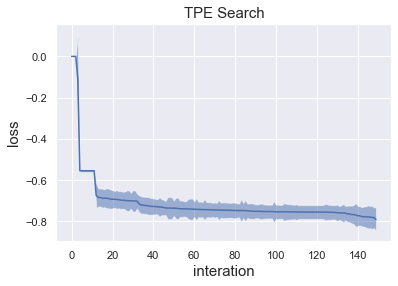

In [36]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 25),
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 1, 6, 1),
    'min_samples_split': hp.uniform('min_samples_split', 0.0, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 30),
    'max_features' : hp.choice('max_features', ['sqrt', 'log2']), 
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.035),
    'bootstrap' : hp.choice('bootstrap', [True, False]),
    'replacement' : hp.choice('replacement', [True, False]),
    'max_samples' : hp.uniform('max_samples', 0.1, 1.0),
    'class_weight' : hp.choice('class_weight', ['balanced', 'balanced_subsample']) 
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'n_estimators': int(params['n_estimators']),
        'criterion': params['criterion'],
        'max_depth': int(params['max_depth']),
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': params['max_features'], 
        'ccp_alpha': params['ccp_alpha'], 
        'bootstrap': params['bootstrap'], 
        'replacement': params['replacement'],
        'max_samples': params['max_samples'],
        'class_weight': params['class_weight'],
        'random_state': seed
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    model = BalancedRandomForestClassifier(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=150,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [38]:
#To pass as dictionary

def create_param_grid(search, criterion, max_features, bootstrap, replacement, class_weight): 
    best_hp_dict = {
        'n_estimators': int(search['n_estimators']),
        'criterion': criterion,
        'max_depth': int(search['max_depth']),
        'min_samples_split': search['min_samples_split'],
        'min_samples_leaf': int(search['min_samples_leaf']),
        'max_features': max_features, 
        'ccp_alpha': search['ccp_alpha'], 
        'bootstrap': bootstrap, 
        'replacement': replacement,
        'class_weight': class_weight,
        'max_samples': search['max_samples'],
        'random_state': seed
    }
    return best_hp_dict

balRF_param = create_param_grid(tpe_search, 'gini', 'sqrt', True, True, 'balanced_subsample')
print(balRF_param)

{'n_estimators': 200, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 0.03676124536433607, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'ccp_alpha': 0.003416982397937504, 'bootstrap': True, 'replacement': True, 'class_weight': 'balanced_subsample', 'max_samples': 0.6791915111880718, 'random_state': 42}


++++++++++++++++++++++++++++++++
 BalancedRandomForestClassifier 
++++++++++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.075       81.481      91.932  
 2      83.582         80        86.773  
 3      85.075       81.481      87.101  
 4      79.104       73.077      81.660  
 5      89.552       87.273      90.760  
 6      82.090       80.645      92.355  
 7      79.104         72        81.762  
 8      89.552       87.273      95.857  
 9      72.727       68.966      84.683  
10      81.818       77.778      88.634  

*** BalancedRandomForestClassifier Mean CV Scores ***
ROC AUC   : 88.152 ± 4.4 %
f1        : 78.997 ± 5.8 %
Accuracy  : 82.768 ± 4.8 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision   

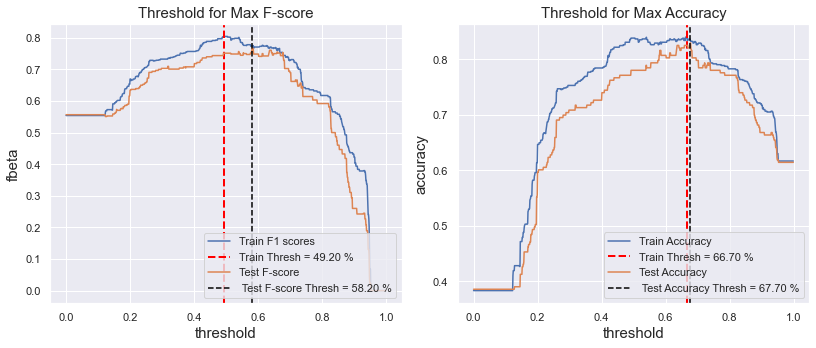

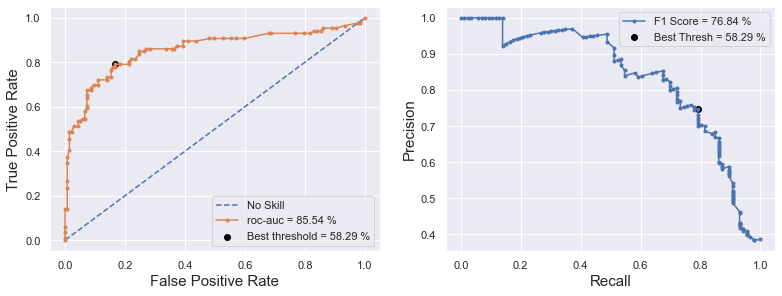

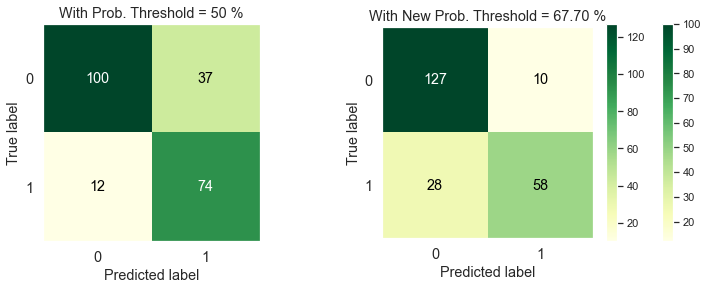

In [39]:
# %%time
balRF = BalancedRandomForestClassifier(**balRF_param)

balRF_val = validate_on_test(balRF, 
                              X_train_pars, 
                              y_train, 
                              X_test_pars, 
                              y_test, 
                              cv = skf, 
                              beta = 'auto', 
                              optimize = 'accuracy')

balRF_val.evaluate_model()

**Breakdown of above output:** <br>
<br>
* The table at the top shows the cross vlidation results at each folds.
<br>
<br>
* After, the cross validations results on the training set are summarized.
<br>
<br>
* Classification report after predicting the model on the validation set.
<br>
<br>
* Scores on the validation set (Accuracy, F1 score and ROC-AUC)
<br>
<br>
* After threshold tuning, the results on Test set qith the best threshold are shown. There is a clear improvement of the metrics after selecting the optimal threshold.
<br>
<br>
* Threshold tuning curve for both train and validation set is displayed for both F1 and accuracy. The vertical line represents the optimal threshold for the highest f1/accuracy score for train and validation set respectively.
<br>
<br>
* ROC-AUC curve and precision-recal curve with optimal threshold marked as a black spot on the plot.
<br>
<br>
* Finally, confusion matrix that shows the results with default 50% threshold and optimal threshold.

++++++++++++++++++++++++++++++++
 BalancedRandomForestClassifier 
++++++++++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      82.222       79.487      87.325  
 2      78.652       74.667      86.984  
 3      75.281       70.270      85.374  
 4      82.022       77.143      84.492  
 5      84.270         80        90.428  
 6      83.146         80        87.647  
 7      85.393       81.159      90.695  
 8      80.899       75.362      86.016  
 9      82.022       79.487      90.428  
10      80.899       75.362      85.642  

Progress: [####################################################################################################]1000/1000 100.00%

*** BalancedRandomForestClassifier Mean CV Scores ***
ROC AUC   : 87.503 ± 2.2 %
f1        : 77.294 ± 3.2 %
Accuracy  : 81.481 ± 2.7 %

-----------------------------------------------------

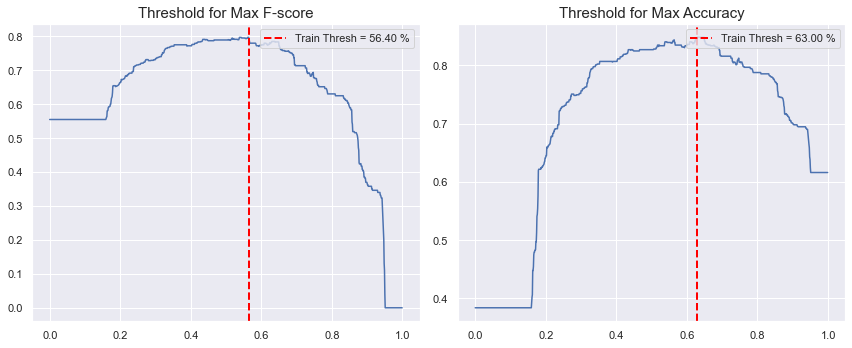

In [41]:
%%time

balRF_pred = predict_unseen_data(balRF, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.63)

balRF_pred.prediction()

sub.Survived = rf_pred.final_pred
sub.to_csv('new_balRF_pred_1.csv', index = False)

#score = 77.77%

## RandomForest

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [03:14<00:00,  2.44s/trial, best loss: -0.7879083331529152]

Best Params: {'bootstrap': 0, 'ccp_alpha': 0.011657973045385562, 'class_weight': 1, 'criterion': 1, 'max_depth': 3.0, 'max_features': 0, 'min_samples_leaf': 2.2221983556155234, 'min_samples_split': 0.028405779245727143, 'n_estimators': 425.0}

Wall time: 3min 30s


Text(0.5, 1.0, 'TPE Search')

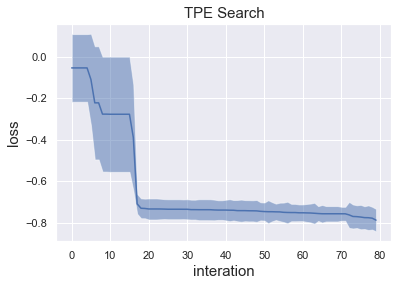

In [11]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 25),
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 1, 6, 1),
    'min_samples_split': hp.uniform('min_samples_split', 0.0, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 30),
    'max_features' : hp.choice('max_features', ['sqrt', 'log2']), 
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.035),
    'bootstrap' : hp.choice('bootstrap', [True]),
    'class_weight' : hp.choice('class_weight', ['balanced', 'balanced_subsample']) 
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'n_estimators': int(params['n_estimators']),
        'criterion': params['criterion'],
        'max_depth': int(params['max_depth']),
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': params['max_features'], 
        'ccp_alpha': params['ccp_alpha'], 
        'bootstrap': params['bootstrap'], 
        'class_weight': params['class_weight'],
        'random_state': seed
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    model = RandomForestClassifier(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=80,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [12]:
#To pass as dictionary

def create_param_grid(search, criterion, max_features, bootstrap, class_weight): 
    best_hp_dict = {
        'n_estimators': int(search['n_estimators']),
        'criterion': criterion,
        'max_depth': int(search['max_depth']),
        'min_samples_split': search['min_samples_split'],
        'min_samples_leaf': int(search['min_samples_leaf']),
        'max_features': max_features, 
        'ccp_alpha': search['ccp_alpha'], 
        'bootstrap': bootstrap, 
        'class_weight': class_weight,
        'random_state': seed
    }
    return best_hp_dict

rf_param = create_param_grid(tpe_search, 'entropy', 'log2', True, 'balanced_subsample')
print(rf_param)

{'n_estimators': 425, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 0.028405779245727143, 'min_samples_leaf': 2, 'max_features': 'log2', 'ccp_alpha': 0.011657973045385562, 'bootstrap': True, 'class_weight': 'balanced_subsample', 'random_state': 42}


++++++++++++++++++++++++
 RandomForestClassifier 
++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.075       81.481      92.355  
 2      83.582         80        86.304  
 3      86.567       82.353      87.195  
 4      79.104       73.077      84.944  
 5      88.060       85.185      90.103  
 6      82.090         80        92.542  
 7      79.104         72        81.905  
 8      89.552       87.273      96.333  
 9      74.242       70.175      82.537  
10      80.303       76.364      87.463  

*** RandomForestClassifier Mean CV Scores ***
ROC AUC   : 88.168 ± 4.4 %
f1        : 78.791 ± 5.4 %
Accuracy  : 82.768 ± 4.5 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

   

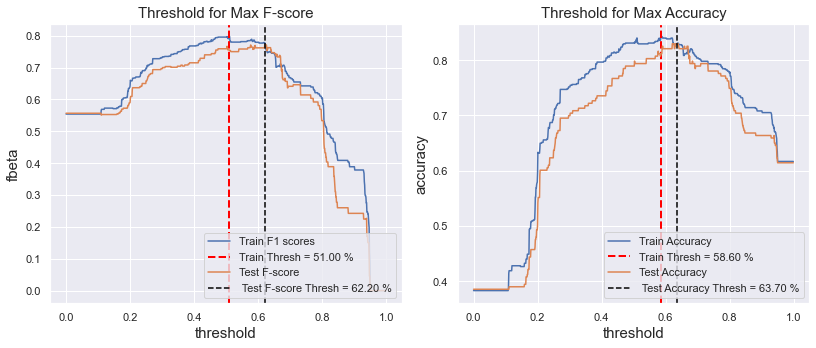

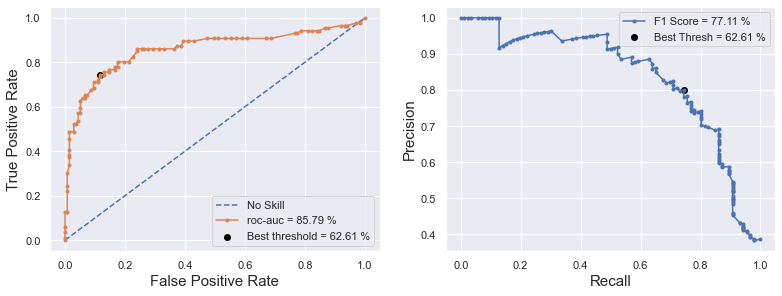

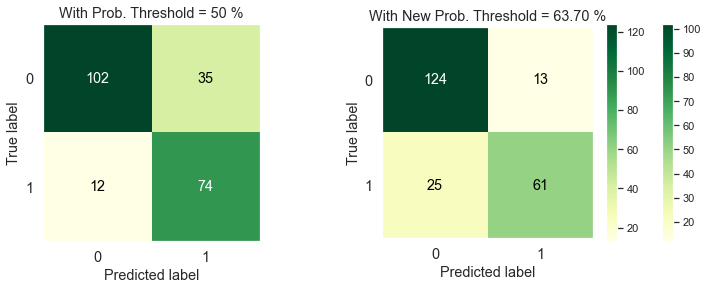

In [13]:
%%time
rf = RandomForestClassifier(**rf_param)

rf_val = validate_on_test(rf, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

rf_val.evaluate_model()

++++++++++++++++++++++++
 RandomForestClassifier 
++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      82.222       79.487      88.260  
 2      79.775       76.316      87.989  
 3      75.281       69.444      84.706  
 4      79.775       72.727      84.679  
 5      85.393       81.690      90.428  
 6      83.146         80        87.781  
 7      85.393       81.159      90.455  
 8      80.899       75.362      85.749  
 9      82.022       78.378        90    
10      80.899       75.362      85.829  

Progress: [####################################################################################################]1000/1000 100.00%

*** RandomForestClassifier Mean CV Scores ***
ROC AUC   : 87.588 ± 2.1 %
f1        : 76.992 ± 3.7 %
Accuracy  : 81.481 ± 2.8 %

-------------------------------------------------------------------------------------

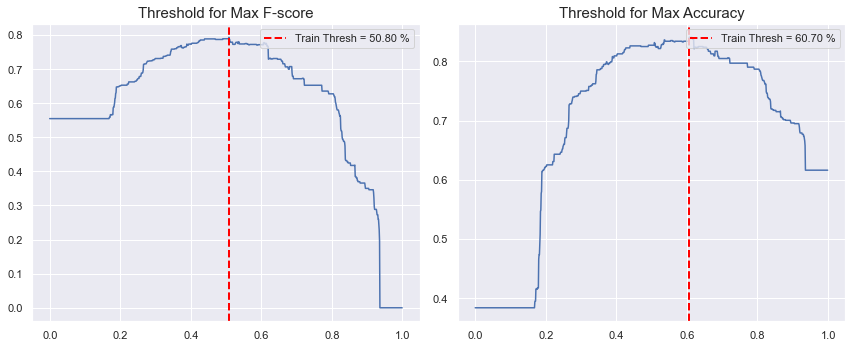

In [42]:
%%time

rf_pred = predict_unseen_data(rf, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.6070)

rf_pred.prediction()

sub.Survived = rf_pred.final_pred
sub.to_csv('new_rf_1.csv', index = False)

#score = 77%

# CatBoost

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [22:24<00:00, 11.20s/trial, best loss: -0.8122342269273457]

Best Params: {'auto_class_weights': 1, 'boosting_type': 0, 'border_count': 9.711787789378182, 'depth': 4.0, 'iterations': 950.0, 'l2_leaf_reg': 43.46621293093142, 'learning_rate': 0.44193711178139783}

Wall time: 22min 24s


Text(0.5, 1.0, 'TPE Search')

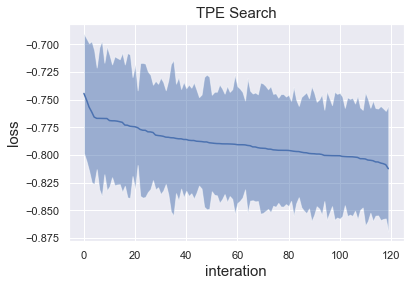

In [52]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL
from catboost import CatBoostClassifier

param_grid = {
    'iterations': hp.quniform('iterations', 200, 1000, 25),
    'depth': hp.quniform('depth', 1, 7, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1)),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1.0, 100.0),
    'border_count': hp.loguniform('border_count', np.log(5), np.log(200)), 
    'auto_class_weights': hp.choice('auto_class_weights', ['Balanced', 'SqrtBalanced']),
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'iterations': int(params['iterations']),
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'boosting_type': params['boosting_type'],
        'l2_leaf_reg': params['l2_leaf_reg'],
        'border_count': int(params['border_count']), 
        'auto_class_weights': params['auto_class_weights']
    }

    # with ** we pass the items in the dictionary as parameters
    
    cat = CatBoostClassifier(verbose = False, loss_function='Logloss', eval_metric='TotalF1', 
                             random_seed = seed)
    
    model = cat.set_params(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=120,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [53]:
def create_param_grid(search, boosting_type, auto_class_weights):
    best_hp_dict = {
        'iterations': int(search['iterations']),
        'depth': int(search['depth']),
        'learning_rate': search['learning_rate'],
        'boosting_type': boosting_type,
        'l2_leaf_reg': search['l2_leaf_reg'],
        'border_count': int(search['border_count']), 
        'auto_class_weights': auto_class_weights,
    }
    return best_hp_dict

cat_param = create_param_grid(tpe_search, 'Ordered', 'SqrtBalanced')
print(cat_param)

{'iterations': 950, 'depth': 4, 'learning_rate': 0.44193711178139783, 'boosting_type': 'Ordered', 'l2_leaf_reg': 43.46621293093142, 'border_count': 9, 'auto_class_weights': 'SqrtBalanced'}


++++++++++++++++++++
 CatBoostClassifier 
++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      83.582       78.431      93.011  
 2      88.060         84        85.647  
 3      91.045       88.462      91.839  
 4      79.104       70.833      86.773  
 5      88.060         84        91.839  
 6      86.567       83.019      92.214  
 7      82.090         76        79.190  
 8      92.537       90.566      94.429  
 9      81.818       76.923      88.439  
10      84.848         80        89.024  

*** CatBoostClassifier Mean CV Scores ***
ROC AUC   : 89.240 ± 4.3 %
f1        : 81.223 ± 5.7 %
Accuracy  : 85.771 ± 4.0 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           0       

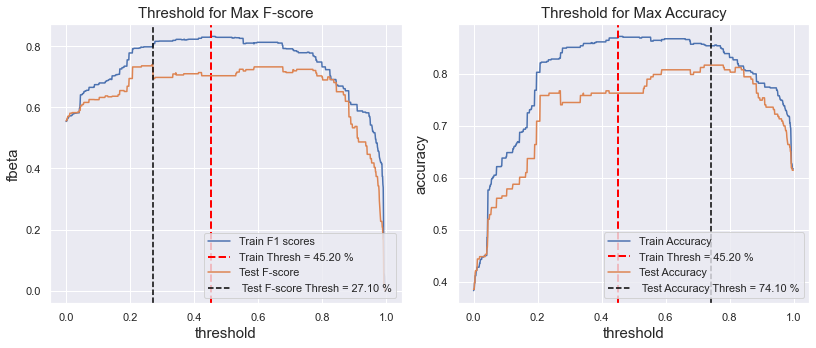

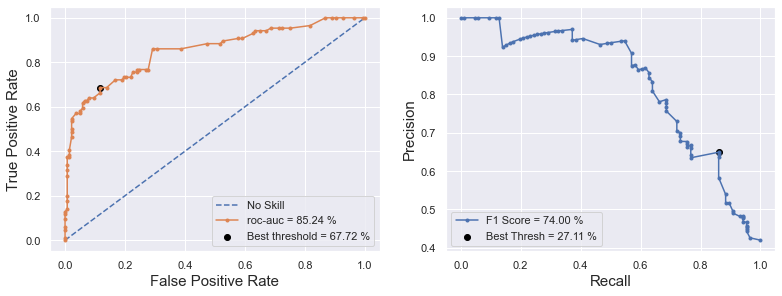

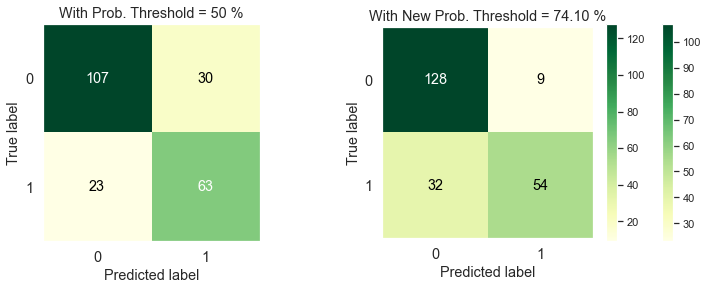

In [54]:
%%time
cat = CatBoostClassifier(verbose = False, loss_function='Logloss', eval_metric='TotalF1', 
                             random_seed = seed, **cat_param)

cat_val = validate_on_test(cat, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

cat_val.evaluate_model()

++++++++++++++++++++
 CatBoostClassifier 
++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      83.333       78.873      88.416  
 2      84.270       79.412      86.217  
 3      84.270       78.125      87.674  
 4      79.775         70        86.337  
 5      85.393         80        89.840  
 6      84.270       78.788      88.690  
 7      91.011       87.879      92.139  
 8      78.652       67.797      84.893  
 9      84.270       78.788      91.524  
10      83.146       75.410      87.193  

Progress: [####################################################################################################]1000/1000 100.00%

*** CatBoostClassifier Mean CV Scores ***
ROC AUC   : 88.292 ± 2.2 %
f1        : 77.507 ± 5.3 %
Accuracy  : 83.839 ± 3.1 %

-----------------------------------------------------------------------------------------------------

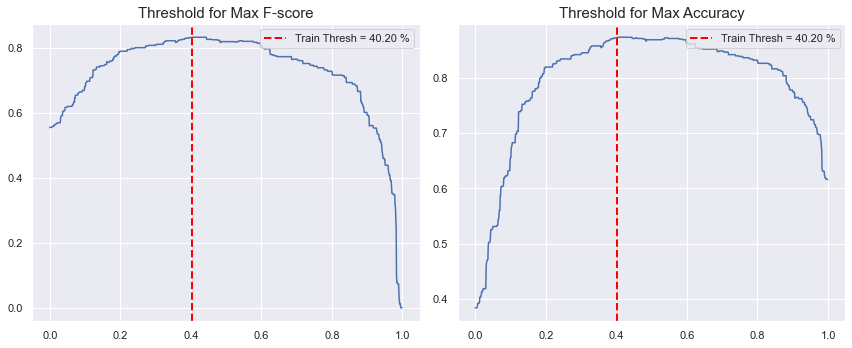

In [18]:
%%time

cat_pred = predict_unseen_data(cat, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.4020)

cat_pred.prediction()

sub.Survived = cat_pred.final_pred
sub.to_csv('new_cat_1.csv', index = False)

#score = 76.79 %

# RGF

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [28:32<00:00, 14.27s/trial, best loss: -0.8040602217033719]

Best Params: {'algorithm': 1, 'calc_prob': 0, 'l2': 0.5523838562552357, 'learning_rate': 0.07855455606959709, 'loss': 0, 'max_leaf': 4531.458023367242, 'min_samples_leaf': 12.864818462440605, 'reg_depth': 1.426141861306805, 'test_interval': 307.3409401330696}

Wall time: 28min 32s


Text(0.5, 1.0, 'TPE Search')

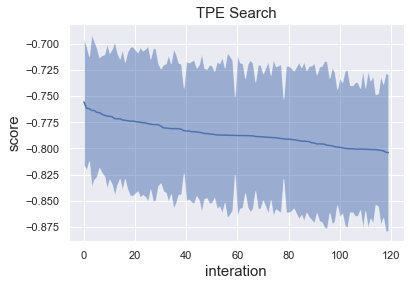

In [19]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL


param_grid = {
    'algorithm':  hp.choice('algorithm', ['RGF', 'RGF_Opt', 'RGF_Sib']),
    'calc_prob': hp.choice('calc_prob', ["softmax", "sigmoid"]),
    'l2': hp.uniform('l2', 0.0001, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
    'loss': hp.choice('loss', ['LS', 'Log', 'Expo']),
    'max_leaf': hp.uniform('max_leaf', 1000, 10000),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 20),
    'reg_depth': hp.uniform('reg_depth', 1.0, 5.0),
    'test_interval': hp.uniform('test_interval', 100, 600)
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'algorithm': params['algorithm'], 
        'calc_prob': params['calc_prob'], 
        'l2': params['l2'], 
        'learning_rate': params['learning_rate'], 
        'loss': params['loss'], 
        'max_leaf': int(params['max_leaf']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'reg_depth': params['reg_depth'], 
        'test_interval': int(params['test_interval'])
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    
    model = RGFClassifier().set_params(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=120,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
)

results.columns = ['algorithm', 'calc_prob', 'l2', 'learning_rate', 'loss', 'max_leaf',
                   'min_samples_leaf', 'reg_depth', 'test_interval', 'score',
                   'score_variance', 'status']

results = results.sort_values(by='score', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='score', data=results)
ax.fill_between(
    results["index"],
    y1=results["score"] - results["score_variance"],
    y2=results["score"] + results["score_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [20]:
def create_param_grid(search, algorithm, calc_prob, loss):
    best_hp_dict = {
        'algorithm': algorithm, 
        'calc_prob': calc_prob, 
        'l2': search['l2'], 
        'learning_rate': search['learning_rate'], 
        'loss': loss, 
        'max_leaf': int(search['max_leaf']),
        'min_samples_leaf': int(search['min_samples_leaf']),
        'reg_depth': search['reg_depth'], 
        'test_interval': int(search['test_interval'])
    }
    return best_hp_dict

rgf_param = create_param_grid(tpe_search, 'RGF_Opt', 'softmax', 'LS')
print(rgf_param)

{'algorithm': 'RGF_Opt', 'calc_prob': 'softmax', 'l2': 0.5523838562552357, 'learning_rate': 0.07855455606959709, 'loss': 'LS', 'max_leaf': 4531, 'min_samples_leaf': 12, 'reg_depth': 1.426141861306805, 'test_interval': 307}


+++++++++++++++
 RGFClassifier 
+++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.075         80        93.340  
 2      88.060       83.333      86.304  
 3      94.030         92        90.760  
 4      82.090         75        79.315  
 5      82.090       73.913      92.448  
 6      83.582       79.245      92.214  
 7      77.612       66.667      83.476  
 8      94.030       92.308      94.905  
 9      87.879       83.333      89.756  
10      84.848       78.261      92.780  

*** RGFClassifier Mean CV Scores ***
ROC AUC   : 89.530 ± 4.7 %
f1        : 80.406 ± 7.5 %
Accuracy  : 85.930 ± 5.0 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           0       0.82      0.87      

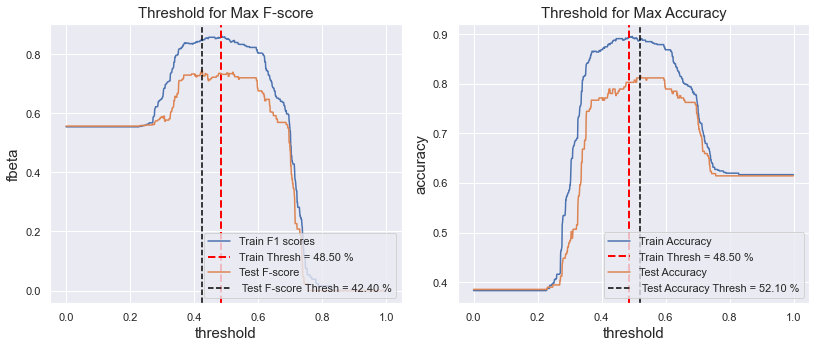

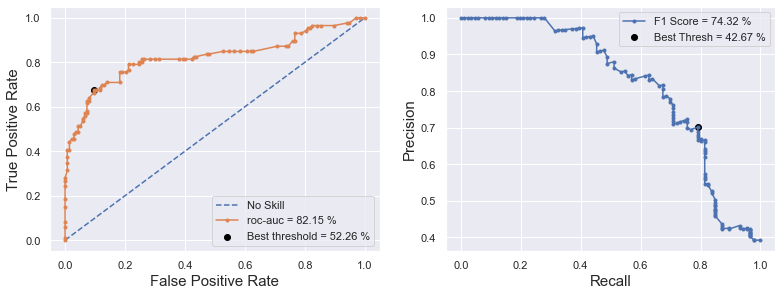

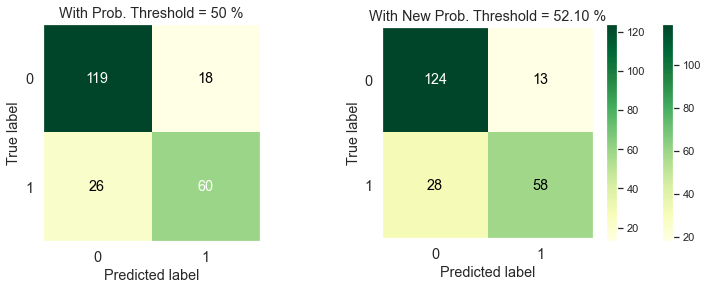

In [21]:
%%time
rgf = RGFClassifier(**rgf_param)

rgf_val = validate_on_test(rgf, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

rgf_val.evaluate_model()

+++++++++++++++
 RGFClassifier 
+++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.556       81.690      88.597  
 2      82.022       77.143      86.058  
 3      84.270       78.125      88.610  
 4      82.022       73.333      86.230  
 5      86.517       81.818      90.508  
 6      86.517       82.353      90.455  
 7      91.011       87.500      93.289  
 8      79.775         70        84.305  
 9      86.517       81.250      91.016  
10      83.146       76.190      86.925  

Progress: [####################################################################################################]1000/1000 100.00%

*** RGFClassifier Mean CV Scores ***
ROC AUC   : 88.599 ± 2.6 %
f1        : 78.940 ± 4.8 %
Accuracy  : 84.735 ± 3.0 %

------------------------------------------------------------------------------------------------------------------------


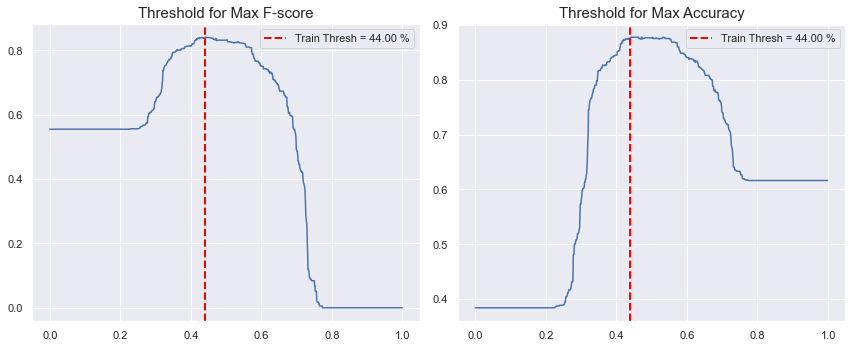

In [22]:
%%time

rgf_pred = predict_unseen_data(rgf, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.44)

rgf_pred.prediction()

sub.Survived = rgf_pred.final_pred
sub.to_csv('new_rgf_1.csv', index = False)

#score =  75.8 %

# XGBoost

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [13:34<00:00,  6.79s/trial, best loss: -0.8027119587890661]

Best Params: {'base_score': 0.39082554104914513, 'booster': 0, 'colsample_bylevel': 0.6044457162836602, 'colsample_bynode': 0.519899279334705, 'colsample_bytree': 0.6541617895263185, 'gamma': 0.01775068000007035, 'learning_rate': 0.09820603542491528, 'max_delta_step': 0.039125244517202375, 'max_depth': 4.0, 'min_child_weight': 1.0, 'n_estimators': 575.0, 'reg_alpha': 0.8265642001676727, 'reg_lambda': 5.96801358633582, 'subsample': 0.6857291870079492}

Wall time: 13min 34s


Text(0.5, 1.0, 'TPE Search')

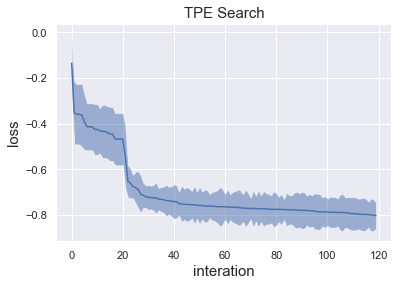

In [23]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 10, 2500, 25),
    'max_depth': hp.quniform('max_depth', 1, 7, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1)),
    'booster': hp.choice('booster', ['gbtree', 'dart', 'gblinear']),
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(10)),
    'subsample': hp.uniform('subsample', 0.50, 0.90),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.50, 0.99),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.50, 0.99),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.50, 0.99),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(20)), 
    'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1), 
    'base_score': hp.uniform('base_score', 0.3, 0.65), 
    'max_delta_step':  hp.loguniform('max_delta_step', np.log(0.01), np.log(10)), 
    'reg_alpha': hp.uniform('reg_alpha', 0.0001, 2.0)
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        # important int, as it takes integers only
        'n_estimators': int(params['n_estimators']),
        # important int, as it takes integers only
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'booster': params['booster'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'colsample_bylevel': params['colsample_bylevel'],
        'colsample_bynode': params['colsample_bynode'],
        'random_state': seed,
        'reg_lambda': int(params['reg_lambda']), 
        'min_child_weight': int(params['min_child_weight']),
        'base_score': params['base_score'], 
        'max_delta_step': int(params['max_delta_step']), 
        'reg_lambda': int(params['reg_lambda'])
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    model = XGBClassifier(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=120,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [24]:
#To pass as dictionary

def create_param_grid(search, booster): #Here, booster represents the cateogircal parameter.
    best_hp_dict = {
        'n_estimators': int(search['n_estimators']),
        # important int, as it takes integers only
        'max_depth': int(search['max_depth']),
        'learning_rate': search['learning_rate'],
        'booster': booster,
        'gamma': search['gamma'],
        'subsample': search['subsample'],
        'colsample_bytree': search['colsample_bytree'],
        'colsample_bylevel': search['colsample_bylevel'],
        'colsample_bynode': search['colsample_bynode'],
        'random_state': seed,
        'reg_lambda': int(search['reg_lambda']), 
        'min_child_weight': int(search['min_child_weight']),
        'base_score': search['base_score'], 
        'max_delta_step': int(search['max_delta_step']), 
        'reg_lambda': int(search['reg_lambda'])
    }
    return best_hp_dict

xgb_param = create_param_grid(tpe_search, 'gbtree')
print(xgb_param)

{'n_estimators': 575, 'max_depth': 4, 'learning_rate': 0.09820603542491528, 'booster': 'gbtree', 'gamma': 0.01775068000007035, 'subsample': 0.6857291870079492, 'colsample_bytree': 0.6541617895263185, 'colsample_bylevel': 0.6044457162836602, 'colsample_bynode': 0.519899279334705, 'random_state': 42, 'reg_lambda': 5, 'min_child_weight': 1, 'base_score': 0.39082554104914513, 'max_delta_step': 0}


+++++++++++++++
 XGBClassifier 
+++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.075         80        92.917  
 2      88.060       83.333      86.773  
 3      92.537       90.196      90.947  
 4      82.090         75        80.722  
 5      82.090       73.913      91.041  
 6      83.582         80        91.839  
 7      80.597       72.340      80.905  
 8      91.045         88        95.190  
 9      87.879       83.333      88.488  
10      83.333       76.596        90    

*** XGBClassifier Mean CV Scores ***
ROC AUC   : 88.882 ± 4.6 %
f1        : 80.271 ± 5.7 %
Accuracy  : 85.629 ± 3.8 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           0       0.83      0.88      

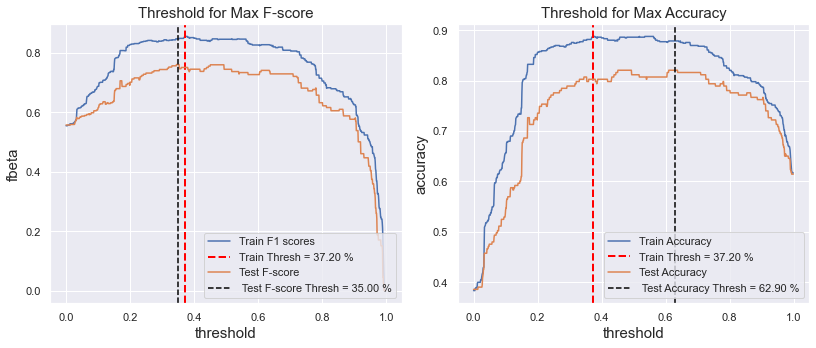

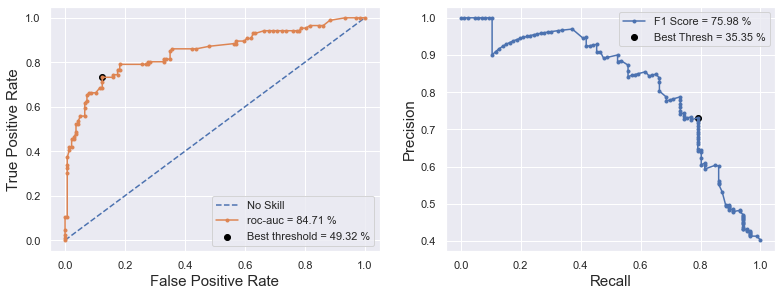

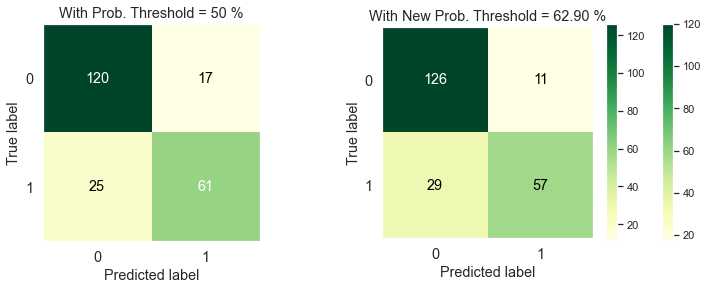

In [25]:
%%time
xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'error', **xgb_param) 

xgb_val = validate_on_test(xgb, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

xgb_val.evaluate_model()

+++++++++++++++
 XGBClassifier 
+++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.556       82.192      87.584  
 2      85.393       81.159      87.169  
 3      84.270       78.125      89.278  
 4      82.022       73.333      85.455  
 5      87.640       83.582      91.070  
 6      84.270         80        90.535  
 7      91.011       87.500      92.139  
 8      80.899       72.131      85.160  
 9      85.393         80        90.374  
10      83.146       76.190      86.417  

Progress: [####################################################################################################]1000/1000 100.00%

*** XGBClassifier Mean CV Scores ***
ROC AUC   : 88.518 ± 2.4 %
f1        : 79.421 ± 4.4 %
Accuracy  : 84.960 ± 2.7 %

------------------------------------------------------------------------------------------------------------------------


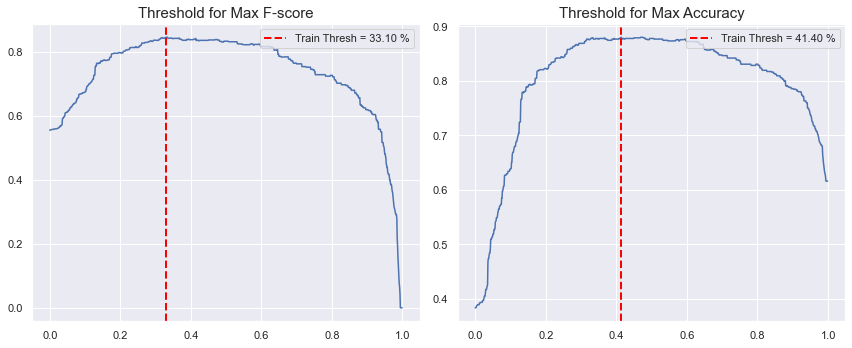

In [26]:
%%time

xgb_pred = predict_unseen_data(xgb, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.4140)

xgb_pred.prediction()

sub.Survived = xgb_pred.final_pred
sub.to_csv('new_xgb_1.csv', index = False)

#score =  75.8 %

# ExtraTrees

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:56<00:00,  1.97s/trial, best loss: -0.7920271930569601]

Best Params: {'bootstrap': 1, 'ccp_alpha': 0.0005206435027054306, 'class_weight': 1, 'criterion': 0, 'max_depth': 6.0, 'max_features': 0, 'min_samples_leaf': 1.430647610827597, 'min_samples_split': 0.019583746183948064, 'n_estimators': 500.0}

Wall time: 4min 56s


Text(0.5, 1.0, 'TPE Search')

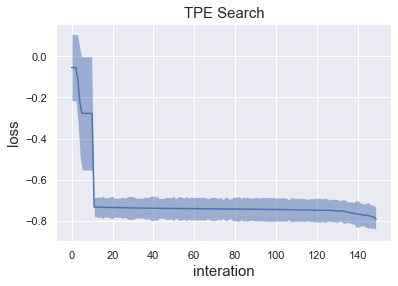

In [27]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 25),
    'criterion' : hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 1, 6, 1),
    'min_samples_split': hp.uniform('min_samples_split', 0.0, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 30),
    'max_features' : hp.choice('max_features', ['sqrt', 'log2']), 
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.035),
    'bootstrap' : hp.choice('bootstrap', [True, False]),
    'class_weight' : hp.choice('class_weight', ['balanced', 'balanced_subsample']) 
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'n_estimators': int(params['n_estimators']),
        'criterion': params['criterion'],
        'max_depth': int(params['max_depth']),
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': params['max_features'], 
        'ccp_alpha': params['ccp_alpha'], 
        'bootstrap': params['bootstrap'], 
        'class_weight': params['class_weight'],
        'random_state': seed
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    model = ExtraTreesClassifier(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=150,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [28]:
#To pass as dictionary

def create_param_grid(search, criterion, max_features, bootstrap, class_weight): 
    best_hp_dict = {
        'n_estimators': int(search['n_estimators']),
        'criterion': criterion,
        'max_depth': int(search['max_depth']),
        'min_samples_split': search['min_samples_split'],
        'min_samples_leaf': int(search['min_samples_leaf']),
        'max_features': max_features, 
        'ccp_alpha': search['ccp_alpha'], 
        'bootstrap': bootstrap, 
        'class_weight': class_weight,
        'random_state': seed
    }
    return best_hp_dict

et_param = create_param_grid(tpe_search, 'gini', 'sqrt', False, 'balanced_subsample')
print(et_param)

{'n_estimators': 500, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 0.019583746183948064, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'ccp_alpha': 0.0005206435027054306, 'bootstrap': False, 'class_weight': 'balanced_subsample', 'random_state': 42}


++++++++++++++++++++++
 ExtraTreesClassifier 
++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      88.060       85.714      93.574  
 2      83.582         80        86.961  
 3      89.552       86.792      89.024  
 4      79.104       73.077      83.255  
 5      83.582       77.551      90.807  
 6      82.090       79.310      91.839  
 7      79.104       70.833      80.762  
 8      91.045       88.889      94.952  
 9      75.758       71.429      84.878  
10      83.333       78.431      89.122  

*** ExtraTreesClassifier Mean CV Scores ***
ROC AUC   : 88.517 ± 4.3 %
f1        : 79.203 ± 6.0 %
Accuracy  : 83.521 ± 4.6 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           

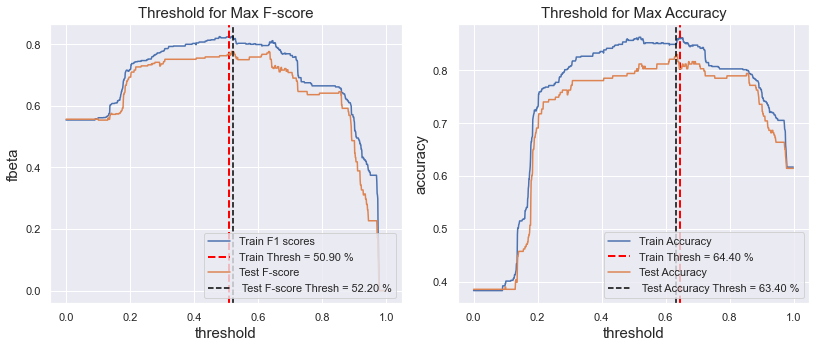

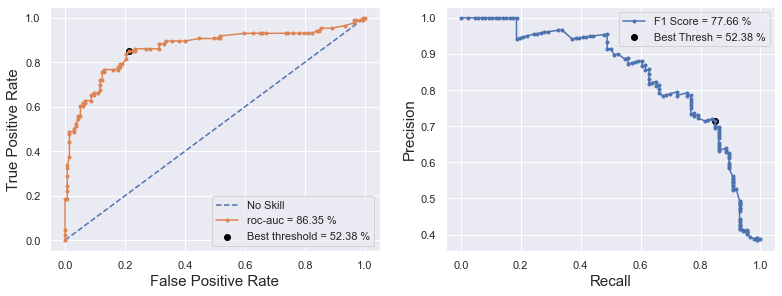

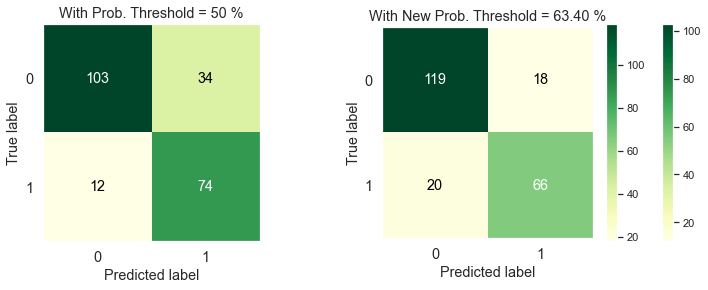

In [29]:
%%time
et = ExtraTreesClassifier(**et_param)

et_val = validate_on_test(et, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

et_val.evaluate_model()

++++++++++++++++++++++
 ExtraTreesClassifier 
++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      82.222       79.487      88.026  
 2      79.775         75        86.905  
 3      78.652       72.464      85.321  
 4      78.652       70.769      83.770  
 5      86.517       83.333      89.947  
 6      83.146       79.452      87.888  
 7      85.393       81.690      90.134  
 8      82.022       75.758      85.321  
 9      80.899       77.333      90.642  
10      79.775       72.727      87.781  

Progress: [####################################################################################################]1000/1000 100.00%

*** ExtraTreesClassifier Mean CV Scores ***
ROC AUC   : 87.573 ± 2.2 %
f1        : 76.801 ± 4.0 %
Accuracy  : 81.705 ± 2.6 %

---------------------------------------------------------------------------------------------

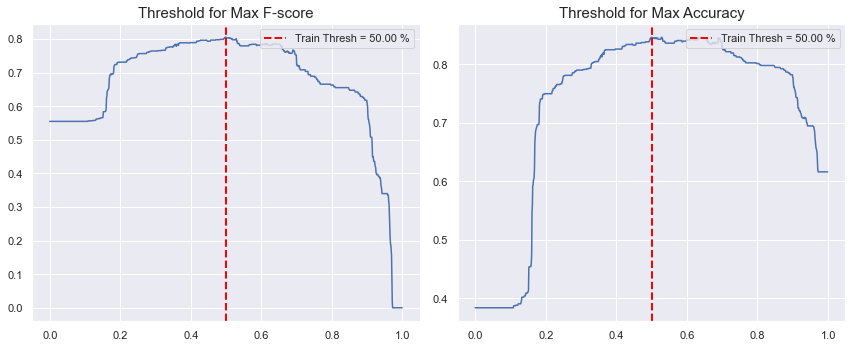

In [56]:
%%time

et_pred = predict_unseen_data(et, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.5)

et_pred.prediction()

sub.Survived = et_pred.final_pred
sub.to_csv('new_et_1.csv', index = False)

#score =  75.8 %

# Calibration

In [57]:
class calibrate_model:
    
    """
    Class for calibrating models. First, the train dataset is further splitted to train and 
    val set. The model is first trained on the training set. The model is then calibrated using
    the valset and then used to predict on the validation set (Xtest) 
    """
    
    def __init__(self, model, Xtrain, ytrain, Xtest, ytest, cv):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        self.cv = cv
        
        self.Xtrain = self.Xtrain.values
        self.ytrain = self.ytrain[self.ytrain.columns[0]].values
        self.Xtest = self.Xtest.values
        self.ytest = self.ytest[self.ytest.columns[0]].values
        
    def calibrate_probability(self):
        
        from sklearn.model_selection import train_test_split
        from sklearn.calibration import CalibratedClassifierCV
        from sklearn.calibration import calibration_curve
        
        #Splitting train set
        train_X, val_X, train_y, val_y = train_test_split(self.Xtrain, 
                                                          self.ytrain, 
                                                          test_size = 0.2, 
                                                          random_state = seed)
        
        
        #uncalibrated model
        
        #Cross validation
        for train_index, test_index in self.cv.split(train_X, train_y): 
            X_train_kfold, X_val_kfold = train_X[train_index], train_X[test_index] 
            y_train_kfold, y_val_kfold = train_y[train_index], train_y[test_index] 
            self.model.fit(X_train_kfold, y_train_kfold)
            
        uc_probs = self.model.predict_proba(self.Xtest)[:, 1]
        uc_fop, uc_mpv = calibration_curve(self.ytest, uc_probs, n_bins=10, normalize=True, 
                                           strategy = 'quantile')
        
        print()
        print(f'Model: {type(self.model).__name__}')
        print()
        print(f'Uncalibrated Brier Score: {metrics.brier_score_loss(self.ytest, uc_probs):.4f}')
        print(f'Uncalibrated ROC-AUC: {metrics.roc_auc_score(self.ytest, uc_probs)*100:.3f}')
    

        #Calibrating Sigmoid Model
        self.sigmoid_cal_model = CalibratedClassifierCV(self.model, method='sigmoid', cv=self.cv)
        self.sigmoid_cal_model.fit(val_X, val_y)
        
        # predict probabilities
        c_sig_probs = self.sigmoid_cal_model.predict_proba(self.Xtest)[:, 1]
        
        print()
        print(f'Calibrated Sigmoid ROC-AUC: {metrics.roc_auc_score(self.ytest, c_sig_probs)*100:.3f} %')
        print()
        
        #Calibrating isotonic Model
        self.isotonic_cal_model = CalibratedClassifierCV(self.model, method='isotonic', cv=self.cv)
        self.isotonic_cal_model.fit(val_X, val_y)
        
        # predict probabilities
        c_iso_probs = self.isotonic_cal_model.predict_proba(self.Xtest)[:, 1]
        
        print(f'Calibrated isotonic ROC-AUC: {metrics.roc_auc_score(self.ytest, c_iso_probs)*100:.3f} %')
        print()
        
        fig = plt.figure(figsize = (12,5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        # reliability diagram for sigmoid
        c_fop, c_mpv = calibration_curve(self.ytest, c_sig_probs, n_bins=10, normalize=True,
                                         strategy = 'quantile')

        # plot calibrated
        ax1.plot([0, 1], [0, 1], linestyle='--');

        # plot un calibrated model reliability 
        ax1.plot(uc_mpv, uc_fop, marker='.', label = 'Uncalibrated');

        # plot calibrated reliability
        ax1.plot(c_mpv, c_fop, marker='.', 
                 label = f'Brier Score = {metrics.brier_score_loss(self.ytest, c_sig_probs):.4f}');

        ax1.set_title('Calibration using Sigmoid')
        ax1.set_ylabel('Fraction of Positives (fop)')
        ax1.set_xlabel('Mean Predicted Value (mpv)')
        ax1.legend();
        plt.tight_layout()
        
        # reliability diagram for isotonic
        c_fop, c_mpv = calibration_curve(self.ytest, c_iso_probs, n_bins=10, normalize=True,
                                         strategy = 'quantile')

        # plot CATBOOST calibrated
        ax2.plot([0, 1], [0, 1], linestyle='--');

        # plot un calibrated model reliability 
        ax2.plot(uc_mpv, uc_fop, marker='.', label = 'Uncalibrated');

        # plot calibrated reliability
        ax2.plot(c_mpv, c_fop, marker='.', 
                 label = f'Brier Score = {metrics.brier_score_loss(self.ytest, c_iso_probs):.4f}');

        ax2.set_title('Calibration using Isotonic')
        ax2.set_ylabel('Fraction of Positives (fop)')
        ax2.set_xlabel('Mean Predicted Value (mpv)')
        ax2.legend();
        
        plt.tight_layout()
        
        plt.show()
#calibrate_model(model, Xtrain, ytrain, Xtest, ytest, cv)
#.calibrate_probability()

### calibrating balanced RF


Model: BalancedRandomForestClassifier

Uncalibrated Brier Score: 0.1572
Uncalibrated ROC-AUC: 84.510

Calibrated Sigmoid ROC-AUC: 80.012 %

Calibrated isotonic ROC-AUC: 79.940 %



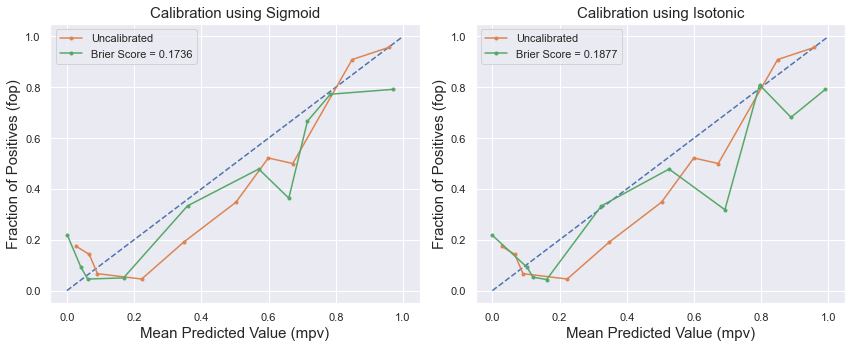

Wall time: 16.5 s


In [58]:
%%time
cal = calibrate_model(balRF, 
                      X_train_pars, 
                      y_train, 
                      X_test_pars, 
                      y_test, 
                      cv = skf)

cal.calibrate_probability()

++++++++++++++++++++++++++++++++++++
 Cal_BalancedRandomForestClassifier 
++++++++++++++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      86.567       82.353      92.167  
 2      85.075       81.481      86.210  
 3      83.582       76.596      87.008  
 4      77.612       69.388      82.083  
 5      85.075       79.167      90.572  
 6      79.104       73.077      90.994  
 7      74.627       62.222      81.333  
 8      89.552       85.714      95.286  
 9      75.758       71.429      84.878  
10      83.333       75.556      88.976  

*** Cal_BalancedRandomForestClassifier Mean CV Scores ***
ROC AUC   : 87.951 ± 4.2 %
f1        : 75.698 ± 6.6 %
Accuracy  : 82.028 ± 4.7 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

          

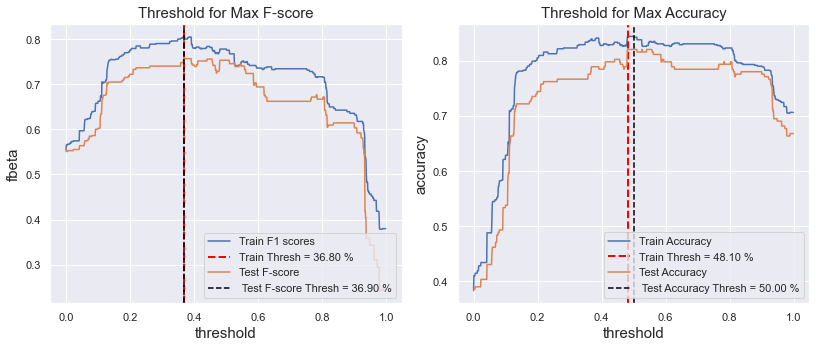

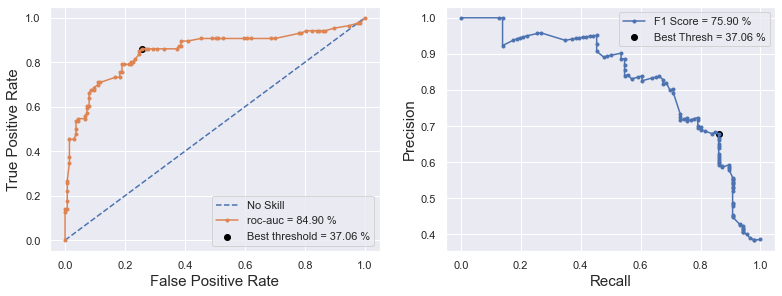

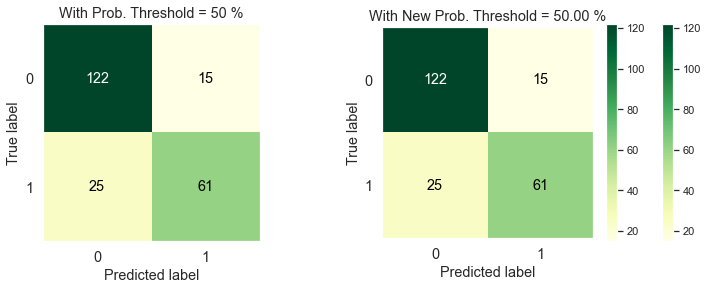

In [59]:
%%time
cal_balRF = cal.isotonic_cal_model 

cal_balRF_val = validate_on_test(cal_balRF, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

cal_balRF_val.evaluate_model()

++++++++++++++++++++++++++++++++++++
 Cal_BalancedRandomForestClassifier 
++++++++++++++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      82.222       77.778      87.948  
 2      82.022       77.143      87.063  
 3      78.652       71.642      85.267  
 4      79.775       70.968      84.545  
 5      85.393       78.689      90.187  
 6      87.640       83.077      87.166  
 7      86.517       81.818      91.203  
 8      79.775       68.966      85.561  
 9      86.517       80.645      90.588  
10      79.775       71.875      85.722  

Progress: [####################################################################################################]1000/1000 100.00%

*** Cal_BalancedRandomForestClassifier Mean CV Scores ***
ROC AUC   : 87.525 ± 2.3 %
f1        : 76.260 ± 4.8 %
Accuracy  : 82.829 ± 3.2 %

-------------------------------------

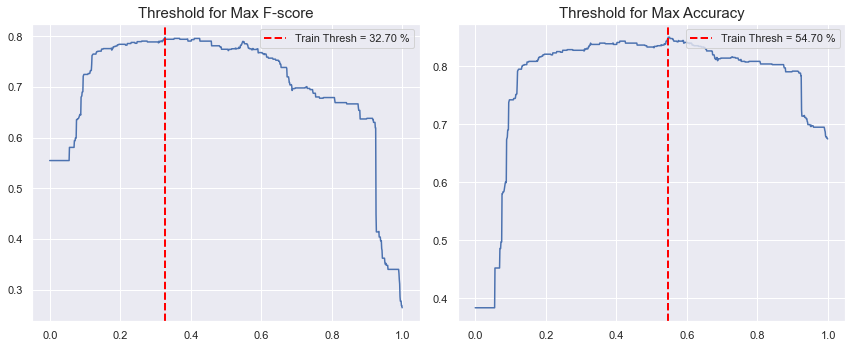

In [60]:
%%time

cal_balRF_pred = predict_unseen_data(cal_balRF, 
                                      train, 
                                      target, 
                                      TEST_DF_pars, 
                                      cv = skf, 
                                      set_threshold=0.5)

cal_balRF_pred.prediction()

sub.Survived = cal_balRF_pred.final_pred
sub.to_csv('cal_balRF_1.csv', index = False)

#score =  77.5 %

### calibrating randomforest


Model: RandomForestClassifier

Uncalibrated Brier Score: 0.1538
Uncalibrated ROC-AUC: 85.677

Calibrated Sigmoid ROC-AUC: 83.454 %

Calibrated isotonic ROC-AUC: 83.237 %



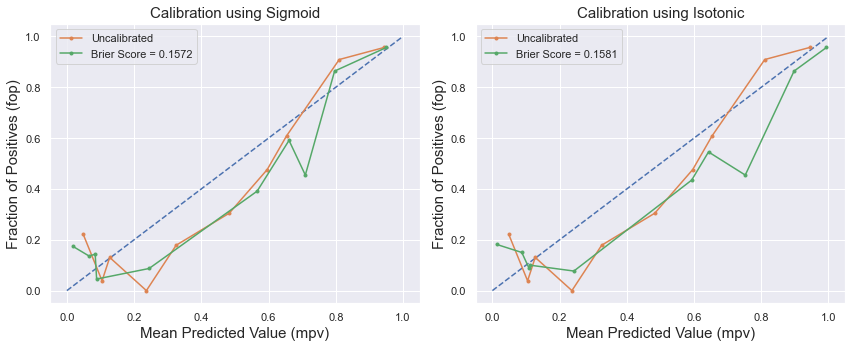

Wall time: 20.6 s


In [61]:
%%time
cal = calibrate_model(rf, 
                      X_train_pars, 
                      y_train, 
                      X_test_pars, 
                      y_test, 
                      cv = skf)

cal.calibrate_probability()

++++++++++++++++++++++++++++
 Cal_RandomForestClassifier 
++++++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      86.567       82.353      92.308  
 2      85.075       81.481      86.445  
 3      83.582       76.596      87.148  
 4      77.612       69.388      82.505  
 5      85.075       79.167      90.056  
 6      82.090       76.923      92.073  
 7      76.119       65.217      81.762  
 8      88.060       83.333      96.143  
 9      75.758       71.429      83.415  
10      81.818         75        87.073  

*** Cal_RandomForestClassifier Mean CV Scores ***
ROC AUC   : 87.893 ± 4.5 %
f1        : 76.089 ± 5.6 %
Accuracy  : 82.176 ± 4.1 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-scor

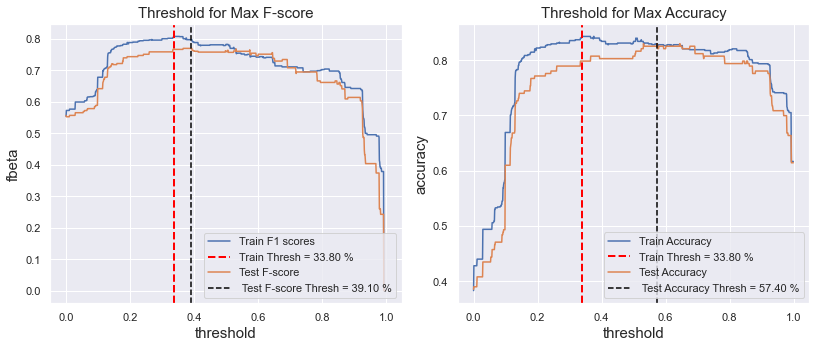

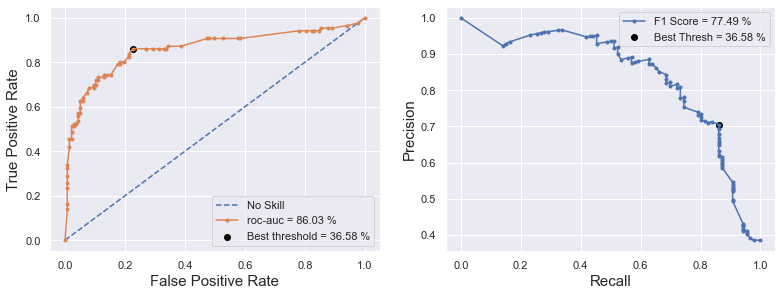

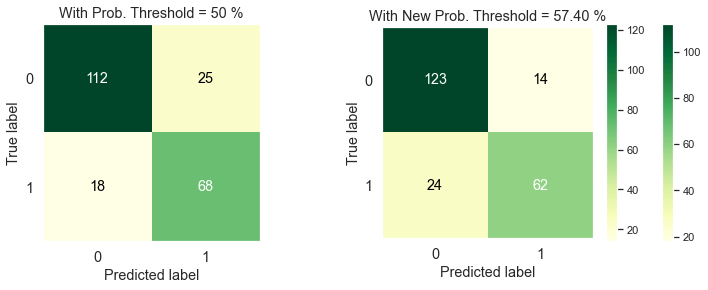

In [62]:
%%time
cal_rf = cal.isotonic_cal_model 

cal_rf_val = validate_on_test(cal_rf, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

cal_rf_val.evaluate_model()

++++++++++++++++++++++++++++
 Cal_RandomForestClassifier 
++++++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      82.222       78.378      87.455  
 2      82.022       76.471      87.778  
 3      78.652       71.642      85.401  
 4      79.775         70        84.706  
 5      85.393       78.689      90.321  
 6      84.270       78.788      87.299  
 7      87.640       83.077      90.455  
 8      79.775         70        85.508  
 9      87.640       82.540      89.920  
10      80.899       73.016      86.497  

Progress: [####################################################################################################]1000/1000 100.00%

*** Cal_RandomForestClassifier Mean CV Scores ***
ROC AUC   : 87.534 ± 2.0 %
f1        : 76.260 ± 4.6 %
Accuracy  : 82.829 ± 3.1 %

---------------------------------------------------------------------

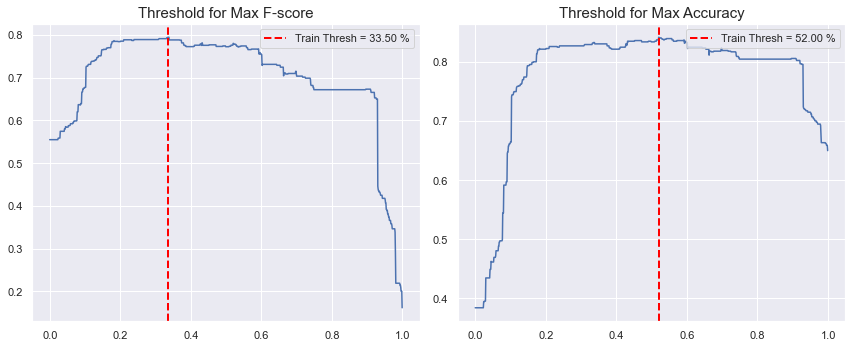

In [64]:
%%time

cal_rf_pred = predict_unseen_data(cal_rf, 
                                      train, 
                                      target, 
                                      TEST_DF_pars, 
                                      cv = skf, 
                                      set_threshold=0.52)

cal_rf_pred.prediction()

sub.Survived = cal_rf_pred.final_pred
sub.to_csv('cal_rf_1.csv', index = False)

#score =   %

### calibrating catboost


Model: CatBoostClassifier

Uncalibrated Brier Score: 0.1529
Uncalibrated ROC-AUC: 85.253

Calibrated Sigmoid ROC-AUC: 80.135 %

Calibrated isotonic ROC-AUC: 79.736 %



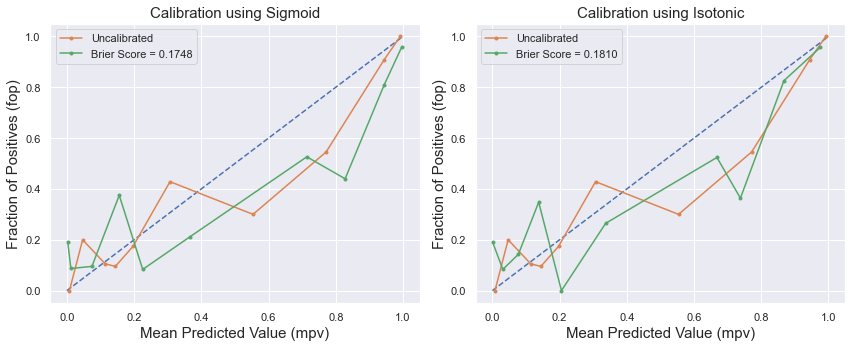

Wall time: 1min 20s


In [67]:
%%time
cal = calibrate_model(cat, 
                      X_train_pars, 
                      y_train, 
                      X_test_pars, 
                      y_test, 
                      cv = skf)

cal.calibrate_probability()

++++++++++++++++++++++++
 Cal_CatBoostClassifier 
++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      83.582       77.551      92.589  
 2      86.567       81.633      87.992  
 3      91.045       88.462      90.619  
 4      80.597       72.340      84.146  
 5      82.090       73.913      92.026  
 6      83.582         80        92.542  
 7      83.582       77.551      80.048  
 8      92.537       90.566      95.762  
 9      78.788       73.077      87.171  
10      81.818         75        87.463  

*** Cal_CatBoostClassifier Mean CV Scores ***
ROC AUC   : 89.036 ± 4.4 %
f1        : 79.009 ± 6.0 %
Accuracy  : 84.419 ± 4.2 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

   

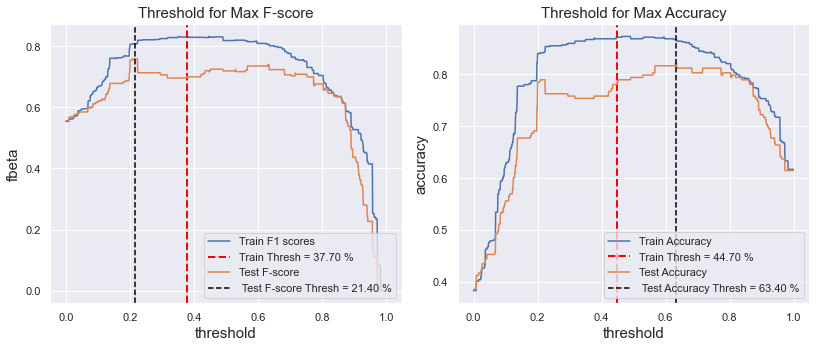

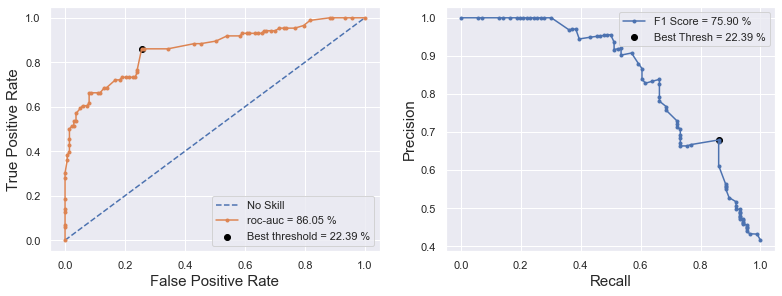

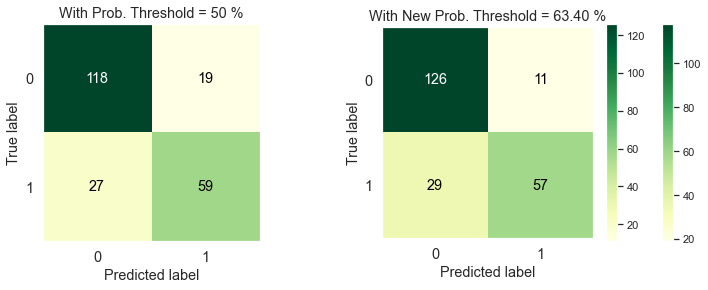

In [68]:
%%time
cal_cat = cal.isotonic_cal_model 

cal_cat_val = validate_on_test(cal_cat, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

cal_cat_val.evaluate_model()